In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'come',
    'away',
    'spin'
]

data = np.concatenate([
    np.load('dataset/seq_come_1627646273.npy'),
    np.load('dataset/seq_away_1627646273.npy'),
    np.load('dataset/seq_spin_1627646273.npy')
], axis=0)

data.shape

(1272, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1272, 30, 99)
(1272,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1272, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1144, 30, 99) (1144, 3)
(128, 30, 99) (128, 3)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                41984     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
33/36 [==========================>...] - ETA: 0s - loss: 25.0842 - acc: 0.5436
Epoch 00001: val_acc improved from -inf to 0.72656, saving model to models/model.h5
36/36 [==============================] - 1s 18ms/step - loss: 24.6293 - acc: 0.5551 - val_loss: 11.3793 - val_acc: 0.7266
Epoch 2/200
35/36 [============================>.] - ETA: 0s - loss: 25.0208 - acc: 0.7268
Epoch 00002: val_acc improved from 0.72656 to 0.80469, saving model to models/model.h5
36/36 [==============================] - 0s 13ms/step - loss: 25.3457 - acc: 0.7273 - val_loss: 24.5188 - val_acc: 0.8047
Epoch 3/200
36/36 [==============================] - ETA: 0s - loss: 45.7178 - acc: 0.4502
Epoch 00003: val_acc did not improve from 0.80469
36/36 [==============================] - 0s 13ms/step - loss: 45.7178 - acc: 0.4502 - val_loss: 181.8392 - val_acc: 0.3281
Epoch 4/200
32/36 [=========================>....] - ETA: 0s - loss: 62.3707 - acc: 0.3662
Epoch 00004: val_acc did not improve from 0.8046

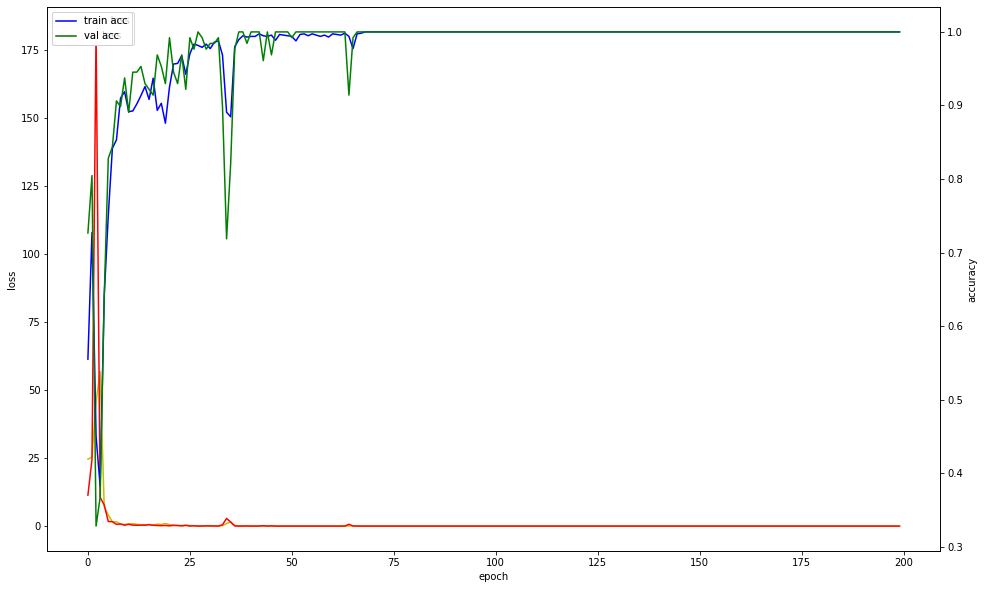

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[94,  0],
        [ 0, 34]],

       [[81,  0],
        [ 0, 47]],

       [[81,  0],
        [ 0, 47]]])